In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2, copy
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from scipy.stats import norm

### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_context("notebook")
sns.set_theme(style="ticks", palette="muted")
%matplotlib inline

In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'data'
stats_dir = 'stats_collection'
plotting_dir = 'plotting'

Notebook is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/RT-comp
Repo is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq


# Comparison between RT polymerases
It has been reported that TGIRT polymerase is superior at producing full length cDNA with RNA template with modified residues (for example see Behrens et al. 2021).
This is especially relevant for tRNAseq because of the highly modified tRNAs.
However, this polymerase is very expensive compared to competing RT polymerases and recently has become unavialable commercially.
As a replacement we have used the Maxima RT polymerases (Thermo), also used in Lucas et al. 2023.

To compare the two polymerases, a pool of 7 barcoded samples were prepared and used as a substrate for both RT PCR reactions with either polymerase.
The cDNA from each was then processed using the standard tRNAseq protocol and sequenced.
In this notebook we are going to compare the resulting data.

In [3]:
# Read the data:
sample_list_fnam = 'sample_list.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))

# Make a dictionary with paths used for data processing:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                stats_dir = stats_dir,
                plotting_dir = plotting_dir)

# Get charge dataframe for aggregated stats:
plot_obj = TRNA_plot(dir_dict, sample_df=sample_df, \
                     stats_fnam='data/stats_collection/ALL_stats_aggregate.csv', \
                     overwrite_dir=False)
tr_df = plot_obj.charge_df.merge(sample_df, on='sample_name_unique')
tr_df['polymerase'] = [h.split('_')[0] for h in tr_df['hue_value']]
tr_df['source'] = [h.split('_')[1] for h in tr_df['hue_value']]
# Remove Ecoli controls, entries with non-unique amino acid annotation
# and entries with non-standard amino acid annotation:
mask = (~tr_df['Ecoli_ctr']) & (tr_df['single_aa']) & (tr_df['AA_letter'].apply(len) == 1)
tr_df = tr_df[mask].copy()

# Required a minimum UMI count of 100 to keep:
min_count = 100
tann2snu = dict()
for snu, tann, cnt in zip(tr_df['sample_name_unique'], \
                          tr_df['tRNA_annotation'], \
                          tr_df['UMIcount']):
    if cnt <= min_count:
        continue

    if tann in tann2snu:
        tann2snu[tann].add(snu)
    else:
        tann2snu[tann] = set()
        tann2snu[tann].add(snu)

# Filter tRNA annotation based on
# all samples having above the minimum count:
all_snu = set(tr_df['sample_name_unique'])
tann_sele = set()
for tann in tann2snu:
    if tann2snu[tann] == all_snu:
        tann_sele.add(tann)

mask = (tr_df['tRNA_annotation'].isin(tann_sele))
cols_sele = ['source', 'polymerase', 'unique_annotation', '5p_cover', 'tRNA_anno_short', 'AA_codon', 'AA_letter', 'mito_codon', 'A_count', 'C_count', 'RPM', 'charge']
tr_df = tr_df.loc[mask, cols_sele].copy().reset_index(drop=True)

Folder exists and overwrite set to false... Doing nothing.


In [4]:
tr_df.head(3)

,source,polymerase,unique_annotation,5p_cover,tRNA_anno_short,AA_codon,AA_letter,mito_codon,A_count,C_count,RPM,charge
0,S1,Maxima,True,False,Ala-TGC,Ala-GCA,A,True,3857,147,2284.685121,96.328671
1,S1,Maxima,True,True,Ala-TGC,Ala-GCA,A,True,1679,64,1055.286135,96.328170
2,S1,Maxima,True,False,Arg-TCG,Arg-CGA,R,True,1596,41,941.083082,97.495418


In [5]:
# Aggregate data based on amino acid indentity
# of the annotation:
aa_df_agg = tr_df.groupby(['source', 'polymerase', '5p_cover', 'AA_letter', 'mito_codon']).agg(RPM=('RPM', 'sum'), charge=('charge', 'mean')).reset_index()

# Assign RPM values to entries with full readthrough
# and those truncated:
aa_df_agg['RPM_full'] = aa_df_agg['5p_cover'] * aa_df_agg['RPM']
aa_df_agg['RPM_trunc'] = (~aa_df_agg['5p_cover']) * aa_df_agg['RPM']
# Aggregate to get full/truncated RPM on the same row:
aa_df_agg = aa_df_agg.groupby(['source', 'polymerase', 'AA_letter', 'mito_codon']).agg(RPM_full=('RPM_full', 'sum'), RPM_trunc=('RPM_trunc', 'sum'), RPM=('RPM', 'sum'), charge=('charge', 'mean')).reset_index()
# Calculate the percentage with full readthrough:
aa_df_agg['p_full'] = 100 * aa_df_agg['RPM_full'] / aa_df_agg['RPM']

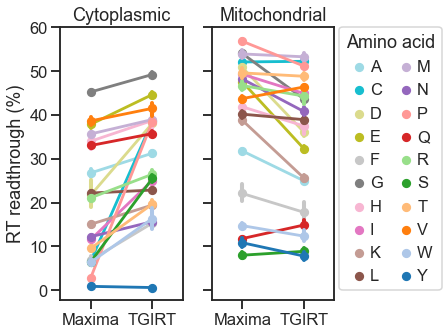

In [6]:
# Plot a comparison of the readthrough:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.6, 5), sharey=True)

mask_mito = (aa_df_agg['mito_codon'])
mask_nomito = (~aa_df_agg['mito_codon'])

aa_ordered_list = sorted(set(aa_df_agg['AA_letter']), reverse=False)

cmap = mpl.colormaps['tab20']
color_list = [cmap(i-1) for i in range(20, 0, -1)]
g1 = sns.pointplot(ax=ax1, data=aa_df_agg[mask_nomito], x='polymerase', y='p_full', hue='AA_letter', \
                   dodge=False, palette=color_list, hue_order=aa_ordered_list, scale=0.7)
g1.set_title('Cytoplasmic')
g1.set(ylabel='RT readthrough (%)', xlabel='')

g2 = sns.pointplot(ax=ax2, data=aa_df_agg[mask_mito], x='polymerase', y='p_full', hue='AA_letter', \
                   dodge=False, palette=color_list, hue_order=aa_ordered_list, scale=0.7)
g2.set_title('Mitochondrial')
g2.set(xlabel='', ylabel='')

g1.legend_ = None
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.04, 1.00), \
                title='Amino acid', borderaxespad=0, ncol=2, \
                columnspacing=0.8, handletextpad=0, handlelength=1.3)

fig.tight_layout()
fig.savefig('data/plotting/readthrough.pdf', bbox_inches='tight')

In [7]:
# Aggregate data by transcript annotation:
mask = tr_df['unique_annotation']
tr_df_agg = tr_df[mask].groupby(['source', 'polymerase', 'tRNA_anno_short']).agg(A_count=('A_count', 'sum'), C_count=('C_count', 'sum'), RPM=('RPM', 'sum'), charge=('charge', 'mean')).reset_index()
tr_df_agg['charge'] = 100 * tr_df_agg['A_count'] / (tr_df_agg['A_count'] + tr_df_agg['C_count'])

# Assign RPM/charge for the two polymerases:
tr_df_agg['RPM_M'] = (tr_df_agg['polymerase'] == 'Maxima') * tr_df_agg['RPM']
tr_df_agg['RPM_T'] = (tr_df_agg['polymerase'] == 'TGIRT') * tr_df_agg['RPM']
tr_df_agg['charge_M'] = (tr_df_agg['polymerase'] == 'Maxima') * tr_df_agg['charge']
tr_df_agg['charge_T'] = (tr_df_agg['polymerase'] == 'TGIRT') * tr_df_agg['charge']

# Aggregate to get the two polymerases on the same row:
tr_df_agg = tr_df_agg.groupby(['source', 'tRNA_anno_short']).agg(RPM_M=('RPM_M', 'sum'), RPM_T=('RPM_T', 'sum'), charge_M=('charge_M', 'max'), charge_T=('charge_T', 'max')).reset_index()

# Re-normalize RPM:
tr_df_agg_sum = tr_df_agg.groupby(['source']).agg(RPM_Msum=('RPM_M', 'sum'), RPM_Tsum=('RPM_T', 'sum')).reset_index()
tr_df_agg = tr_df_agg.merge(tr_df_agg_sum, on='source')
tr_df_agg['RPM_M'] = tr_df_agg['RPM_M'] * (1e6 / tr_df_agg['RPM_Msum'])
tr_df_agg['RPM_T'] = tr_df_agg['RPM_T'] * (1e6 / tr_df_agg['RPM_Tsum'])

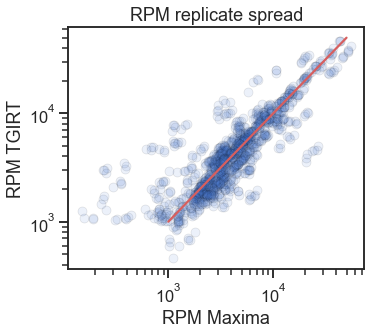

In [8]:
# Plot RPM comparison between the two polymerases:
fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 5))
min_mask = (tr_df_agg['RPM_M'] > 1000) | (tr_df_agg['RPM_T'] > 1000)
g1 = sns.scatterplot(ax=ax1, data=tr_df_agg[min_mask], x='RPM_M', y='RPM_T', \
                     zorder=5, alpha=0.1, \
                     edgecolor='black', linewidth=0.7)
g1.set_yscale('log', base=10)
g1.set_xscale('log', base=10)
g1.set(xlabel='RPM Maxima', ylabel='RPM TGIRT')
g1.set_title('RPM replicate spread')

ax1.plot([1000, 50000], [1000, 50000], c='r', zorder=10)
fig.tight_layout()
fig.savefig('data/plotting/RPM-comp.pdf', bbox_inches='tight')

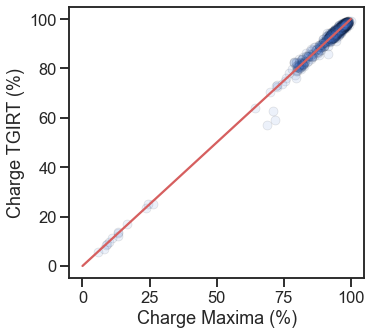

In [9]:
# Plot charge comparison between the two polymerases:
fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 5))
min_mask = (tr_df_agg['RPM_M'] > 1000) | (tr_df_agg['RPM_T'] > 1000)
g1 = sns.scatterplot(ax=ax1, data=tr_df_agg[min_mask], x='charge_M', y='charge_T', \
                     zorder=5, alpha=0.1, \
                     edgecolor='black', linewidth=0.7)
g1.set(xlabel='Charge Maxima (%)', ylabel='Charge TGIRT (%)')
ax1.plot([0, 100], [0, 100], c='r', zorder=10)
fig.tight_layout()
fig.savefig('data/plotting/charge-comp.pdf', bbox_inches='tight')

In [10]:
# Calculate the RPM and charge difference:
tr_df_agg['charge_diff'] = tr_df_agg['charge_M'] - tr_df_agg['charge_T']
tr_df_agg['RPM_diff'] = 100 * (tr_df_agg['RPM_M'] - tr_df_agg['RPM_T']) / ((tr_df_agg['RPM_M'] + tr_df_agg['RPM_T'])/2)

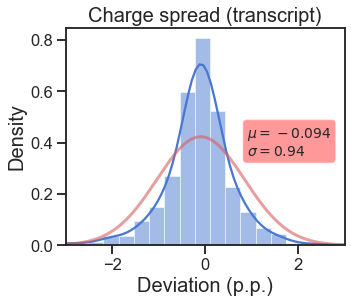

In [11]:
# Plot the distribution of the charge difference (in percentage points):
min_mask = (tr_df_agg['RPM_M'] > 1000) | (tr_df_agg['RPM_T'] > 1000)
std = np.std(tr_df_agg.loc[min_mask, 'charge_diff'].values)
mean = np.mean(tr_df_agg.loc[min_mask, 'charge_diff'].values)
hmin = np.min(tr_df_agg.loc[min_mask, 'charge_diff'].values)
hmax = np.max(tr_df_agg.loc[min_mask, 'charge_diff'].values)

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
g1 = sns.histplot(ax=ax1, data=tr_df_agg[min_mask], x='charge_diff', \
                  kde=True, bins=50, stat='density')
g1.set(xlim=(-3, 3))
g1.set_xlabel('Deviation (p.p.)', fontsize=20)
g1.set_ylabel('Density', fontsize=20)
g1.set_title('Charge spread (transcript)', fontsize=20)


# Overlay the gaussian pdf in addtion
# to the kernel density estimate from Seaborn:
x = np.linspace(hmin, hmax, 1000)
ax1.plot(x, norm.pdf(x, loc=mean, scale=std), 'r-', lw=3, alpha=0.6)

anno_str = '$\mu={:.2}$\n$\sigma={:.2}$'.format(mean, std)
props = dict(boxstyle='round', facecolor='red', alpha=0.4)
ax1.text(0.65, 0.55, anno_str, transform=ax1.transAxes, fontsize=14,
         verticalalignment='top', bbox=props);

fig.savefig('data/plotting/charge-dev-dist.pdf', bbox_inches='tight')

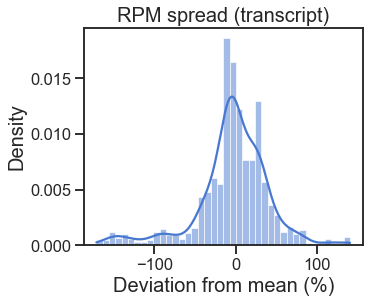

In [12]:
# Plot the distribution of the RPM difference (in percentage from the mean):
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
min_mask = (tr_df_agg['RPM_M'] > 1000) | (tr_df_agg['RPM_T'] > 1000)
g1 = sns.histplot(ax=ax1, data=tr_df_agg[min_mask], x='RPM_diff', \
                  kde=True, bins=40, stat='density')
g1.set_xlabel('Deviation from mean (%)', fontsize=20)
g1.set_ylabel('Density', fontsize=20);
g1.set_title('RPM spread (transcript)', fontsize=20)

fig.savefig('data/plotting/RPM-dev-dist.pdf', bbox_inches='tight')